# Import all Modules

In [ ]:
%pip install intel_extension_for_pytorch

In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import intel_extension_for_pytorch as ipex
from glob import glob
import matplotlib.pyplot as plt
import xml.etree.ElementTree as xet
from sklearn.model_selection import train_test_split

# Check if Cuda is Available

In [2]:
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 1


In [3]:
%pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.7/793.7 kB 20.7 MB/s eta 0:00:0000:01


In [4]:
%pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 3.7 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 214.4/214.4 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.1 MB/s eta 0:00:00:00:01
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.6
    Uninstalling widgetsnbextension-3.6.6:
      Successfully uninstalled widgetsnbextension-3.6.6
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


# Setting up the dataset paths

In [5]:
dataset_path = '/kaggle/input/car-plate-detection'

In [6]:
import re

def the_number_in_the_string(filename):
    """
    Extracts the first sequence of digits from the given filename string and returns it as an integer.
    If no digits are found, returns 0.

    Parameters:
    filename (str): The input string to search for digits.

    Returns:
    int: The first sequence of digits found in the input string, or 0 if no digits are found.
    """
    # Search for the first occurrence of one or more digits in the filename
    match = re.search(r'(\d+)', filename)
    
    # If a match is found, return the matched number as an integer
    if match:
        return int(match.group(0))
    # If no match is found, return 0
    else:
        return 0

# Example usage
#print(the_number_in_the_string("file123.txt"))  # Output: 123
#print(the_number_in_the_string("no_numbers_here"))  # Output: 0

# Formatting the XML File and creating DF

In [7]:
labels_dict = dict(
    img_path=[], 
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[]
)

In [8]:
# Get the list of XML files from the annotations directory
xml_files = glob(f'{dataset_path}/annotations/*.xml')

In [9]:
# Process each XML file, sorted by the numerical value in the filename
for filename in sorted(xml_files, key=the_number_in_the_string):
    # Parse the XML file
    info = xet.parse(filename)
    root = info.getroot()
    
    # Find the 'object' element in the XML and extract bounding box information
    member_object = root.find('object')
    labels_info = member_object.find('bndbox')
    xmin = int(labels_info.find('xmin').text)
    xmax = int(labels_info.find('xmax').text)
    ymin = int(labels_info.find('ymin').text)
    ymax = int(labels_info.find('ymax').text)
    
    # Get the image filename and construct the full path to the image
    img_name = root.find('filename').text
    img_path = os.path.join(dataset_path, 'images', img_name)

    # Append the extracted information to the respective lists in the dictionary
    labels_dict['img_path'].append(img_path)
    labels_dict['xmin'].append(xmin)
    labels_dict['xmax'].append(xmax)
    labels_dict['ymin'].append(ymin)
    labels_dict['ymax'].append(ymax)
    
    # Read the image to get its dimensions
    height, width, _ = cv2.imread(img_path).shape
    labels_dict['img_w'].append(width)
    labels_dict['img_h'].append(height)
    
# Convert the dictionary to a pandas DataFrame
alldata = pd.DataFrame(labels_dict)

# Display the DataFrame
alldata

,img_path,xmin,xmax,ymin,ymax,img_w,img_h
0,/kaggle/input/car-plate-detection/images/Cars0...,226,419,125,173,500,268
1,/kaggle/input/car-plate-detection/images/Cars1...,134,262,128,160,400,248
2,/kaggle/input/car-plate-detection/images/Cars2...,229,270,176,193,400,400
3,/kaggle/input/car-plate-detection/images/Cars3...,142,261,128,157,400,225
4,/kaggle/input/car-plate-detection/images/Cars4...,156,503,82,253,590,350
...,...,...,...,...,...,...,...
428,/kaggle/input/car-plate-detection/images/Cars4...,142,258,128,157,400,225
429,/kaggle/input/car-plate-detection/images/Cars4...,86,208,166,195,301,400
430,/kaggle/input/car-plate-detection/images/Cars4...,38,116,159,197,400,225
431,/kaggle/input/car-plate-detection/images/Cars4...,55,343,82,147,400,192


In [10]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
# Use 10% of the data for the test set
train, test = train_test_split(alldata, test_size=1/10, random_state=42)

# Split the training data further into training and validation sets
# Use 8/9 of the remaining data for the training set, resulting in an 80/10/10 split overall
train, val = train_test_split(train, train_size=8/9, random_state=42)

# Print the number of samples in each set
print(f'''
      len(train) = {len(train)}
      len(val) = {len(val)}
      len(test) = {len(test)}
''')



      len(train) = 345
      len(val) = 44
      len(test) = 44



In [11]:
# Remove the 'datasets' directory if it exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

In [12]:
def make_split_folder_in_yolo_format(split_name, split_df):
    """
    Creates a folder structure for a dataset split (train/val/test) in YOLO format.

    Parameters:
    split_name (str): The name of the split (e.g., 'train', 'val', 'test').
    split_df (pd.DataFrame): The DataFrame containing the data for the split.

    The function will create 'labels' and 'images' subdirectories under 'datasets/cars_license_plate/{split_name}',
    and save the corresponding labels and images in YOLO format.
    """
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    # Create directories for labels and images
    os.makedirs(labels_path)
    os.makedirs(images_path)
    
    # Iterate over each row in the DataFrame
    for _, row in split_df.iterrows():
        img_name, img_extension = os.path.splitext(os.path.basename(row['img_path']))
        
        # Calculate YOLO format bounding box coordinates
        x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
        y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
        width = (row['xmax'] - row['xmin']) / row['img_w']
        height = (row['ymax'] - row['ymin']) / row['img_h']

        # Save the label in YOLO format
        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write(f"0 {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}\n")
            
        # Copy the image to the images directory
        shutil.copy(row['img_path'], os.path.join(images_path, img_name + img_extension))
    
    print(f"Created '{images_path}' and '{labels_path}'")

In [13]:
# Create YOLO format folders for train, validation, and test splits
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


In [14]:
# Directory paths
image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

In [15]:
# Get the first image file
image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[0]

# Construct paths for the image and its corresponding label
image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

# Load the image using OpenCV
image = cv2.imread(image_path)
# Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Read the label file to get bounding box information
with open(label_path, 'r') as f:
    lines = f.readlines()

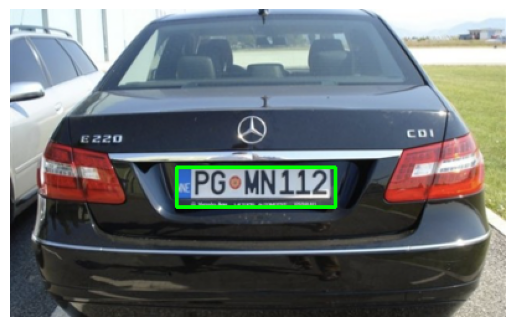

In [16]:
# Plot the bounding box on the image
for line in lines:
    # Parse the label file line to extract bounding box information
    class_id, x_center, y_center, width, height = map(float, line.strip().split())
    img_height, img_width, _ = image.shape

    # Convert YOLO format to bounding box format
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    # Calculate the top-left and bottom-right coordinates of the bounding box
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Draw the bounding box on the image using a green rectangle
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

# Display the image with bounding box using matplotlib
plt.imshow(image)
plt.axis('off')  # Hide the axis
plt.show()  # Display the image

In [17]:
# Define the content of the datasets.yaml file
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 1

# class names
names: ['license_plate']
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)

In [18]:
from ultralytics import YOLO
model = YOLO('yolov8n.pt')
model = ipex.optimize(model)

100%|██████████| 6.25M/6.25M [00:00<00:00, 106MB/s]


In [19]:
model.train(
    data='datasets.yaml',  # Path to the dataset configuration file
    epochs=100,            # Number of training epochs
    batch=16,              # Batch size
    device='cuda',         # Use GPU for training
    imgsz=320,             # Image size (width and height) for training
    cache=True             # Cache images for faster training
)

Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=datasets.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=320, save=True, save_period=-1, cache=True, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=T

100%|██████████| 755k/755k [00:00<00:00, 22.1MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks with YOLOv8n...
AMP: checks passed ✅


train: Scanning /kaggle/working/datasets/cars_license_plate_new/train/labels... 345 images, 0 backgrounds, 0 corrupt: 100%|██████████| 345/345 [00:00<00:00, 501.41it/s]

train: New cache created: /kaggle/working/datasets/cars_license_plate_new/train/labels.cache



train: Caching images (0.1GB RAM): 100%|██████████| 345/345 [00:01<00:00, 194.78it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/datasets/cars_license_plate_new/val/labels... 44 images, 0 backgrounds, 0 corrupt: 100%|██████████| 44/44 [00:00<00:00, 558.01it/s]

val: New cache created: /kaggle/working/datasets/cars_license_plate_new/val/labels.cache



val: Caching images (0.0GB RAM): 100%|██████████| 44/44 [00:00<00:00, 197.06it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 320 train, 320 val
Using 4 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100     0.749G      1.749      2.939       1.35         20        320: 100%|██████████| 22/22 [00:04<00:00,  5.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         44         44    0.00398      0.909      0.236      0.081



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.694G      1.525      1.479      1.147         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.11it/s]

                   all         44         44    0.00467      0.818     0.0364     0.0209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.703G      1.474      1.321      1.172         21        320: 100%|██████████| 22/22 [00:02<00:00, 10.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.33it/s]


                   all         44         44      0.641     0.0419      0.325      0.156

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.709G      1.503      1.342      1.153         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.44it/s]


                   all         44         44      0.818      0.523      0.669       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.709G      1.563      1.329      1.213         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


                   all         44         44      0.535      0.795      0.599      0.298

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.703G       1.47      1.167       1.18         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.55it/s]


                   all         44         44      0.323      0.295      0.223     0.0914

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.709G      1.445       1.15      1.166         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.67it/s]


                   all         44         44      0.733      0.811      0.776      0.334

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.703G      1.415      1.126       1.17         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.21it/s]


                   all         44         44      0.889        0.5      0.646      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.709G      1.409      1.079      1.145         23        320: 100%|██████████| 22/22 [00:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.94it/s]

                   all         44         44      0.791      0.773      0.761      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.703G      1.447      1.074      1.129         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.14it/s]


                   all         44         44      0.624      0.705      0.687      0.332

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100     0.709G      1.342      0.964      1.114         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.73it/s]

                   all         44         44      0.695      0.886       0.74      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100     0.703G      1.332     0.9675       1.13         22        320: 100%|██████████| 22/22 [00:02<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.03it/s]


                   all         44         44      0.836      0.813      0.853      0.491

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100     0.709G      1.324     0.9138      1.136         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


                   all         44         44      0.895      0.864      0.885      0.453

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100     0.703G       1.35     0.9263      1.154         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.42it/s]

                   all         44         44      0.921      0.932      0.923      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100     0.709G       1.31     0.9213      1.117         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.97it/s]

                   all         44         44      0.964      0.864      0.927      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100       0.7G      1.256     0.8877      1.082         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.46it/s]

                   all         44         44      0.874      0.886       0.87      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.709G      1.259     0.8575      1.114         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


                   all         44         44      0.924      0.833      0.885       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.703G      1.226     0.8235      1.091         24        320: 100%|██████████| 22/22 [00:01<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.76it/s]

                   all         44         44          1      0.816        0.9      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.709G      1.238     0.8075      1.079         17        320: 100%|██████████| 22/22 [00:02<00:00, 10.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]


                   all         44         44      0.909      0.886      0.894      0.422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.703G      1.227     0.7625      1.041         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.87it/s]

                   all         44         44      0.812      0.864      0.854      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.709G      1.262     0.7999      1.093         16        320: 100%|██████████| 22/22 [00:02<00:00, 10.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.64it/s]

                   all         44         44      0.898      0.841      0.856      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.703G      1.252       0.81      1.084         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


                   all         44         44      0.899      0.811       0.88      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.709G      1.246     0.7943      1.074         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.48it/s]


                   all         44         44      0.858      0.909      0.903      0.482

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.703G      1.197     0.7684      1.071         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.70it/s]

                   all         44         44      0.903      0.848      0.887      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.709G      1.181     0.7757      1.066         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.98it/s]

                   all         44         44      0.903      0.845      0.885      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.703G       1.19     0.7542       1.05         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]

                   all         44         44      0.927      0.795      0.857      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.709G      1.211     0.7605      1.065         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.43it/s]


                   all         44         44      0.825      0.854       0.82      0.403

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.703G      1.188     0.7307      1.066         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.70it/s]

                   all         44         44      0.837      0.816      0.827       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.709G      1.161     0.7547      1.046         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.12it/s]


                   all         44         44      0.908      0.864      0.911       0.49

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.703G      1.137     0.7079      1.049         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]

                   all         44         44      0.961      0.795      0.879      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.707G      1.148     0.7138      1.035         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.09it/s]

                   all         44         44      0.932      0.841      0.902      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.703G      1.111     0.7164      1.044         22        320: 100%|██████████| 22/22 [00:02<00:00, 10.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.10it/s]


                   all         44         44      0.864      0.863      0.898      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.709G        1.1     0.6999      1.042         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.03it/s]

                   all         44         44      0.808      0.886      0.854      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.703G      1.122     0.7014      1.028         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.22it/s]

                   all         44         44        0.9      0.819       0.89      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.709G      1.118     0.6906      1.034         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


                   all         44         44      0.902      0.818      0.873      0.469

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.703G      1.124     0.7287      1.017         23        320: 100%|██████████| 22/22 [00:01<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.60it/s]

                   all         44         44      0.848      0.886      0.873      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.709G      1.052     0.6528      1.001         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.62it/s]

                   all         44         44      0.916      0.841      0.909      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.703G      1.105     0.6824       1.03         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.81it/s]

                   all         44         44      0.904      0.818      0.903      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.707G        1.1       0.66       1.03         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]


                   all         44         44      0.931      0.841      0.901      0.461

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.703G      1.045      0.657      1.008         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.50it/s]

                   all         44         44      0.809      0.886      0.891      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.709G      1.095     0.6684      1.029         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.43it/s]

                   all         44         44      0.878      0.795      0.909      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.703G      1.103      0.659      1.011         18        320: 100%|██████████| 22/22 [00:02<00:00, 10.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.59it/s]

                   all         44         44      0.858      0.841      0.839      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.709G      1.044     0.6461     0.9965         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.99it/s]

                   all         44         44      0.855      0.864      0.841      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.703G      1.054      0.624     0.9969         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.28it/s]


                   all         44         44      0.948      0.833      0.913      0.496

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.707G      1.061     0.6522      1.009         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.67it/s]


                   all         44         44      0.889      0.773      0.851      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.703G      1.033     0.6185      1.003         20        320: 100%|██████████| 22/22 [00:02<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.93it/s]

                   all         44         44       0.81      0.909      0.876      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.709G       1.02     0.6125      1.004         26        320: 100%|██████████| 22/22 [00:02<00:00, 10.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.56it/s]


                   all         44         44      0.906      0.873      0.914      0.511

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.703G     0.9859     0.5993     0.9857         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]

                   all         44         44      0.968      0.818      0.907      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.709G      1.027     0.6094     0.9973         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.08it/s]

                   all         44         44      0.961      0.795      0.897      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.703G      0.971     0.5828     0.9733         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.08it/s]

                   all         44         44      0.923      0.864      0.911      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.707G     0.9474     0.5986     0.9954         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.68it/s]

                   all         44         44      0.949       0.84      0.903       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.703G     0.9935     0.5949     0.9893         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.20it/s]

                   all         44         44      0.889      0.795      0.832      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.709G     0.9674     0.5926      0.973         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.70it/s]


                   all         44         44      0.911      0.818      0.895      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.703G     0.9526     0.5775     0.9684         14        320: 100%|██████████| 22/22 [00:02<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.27it/s]


                   all         44         44      0.851      0.909       0.91      0.495

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.709G     0.9657     0.5821     0.9717         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.32it/s]

                   all         44         44      0.846      0.886       0.86      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.703G     0.8686     0.5422     0.9351         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.08it/s]

                   all         44         44      0.885      0.909      0.913      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.707G     0.9149     0.5519     0.9864         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.69it/s]

                   all         44         44      0.869      0.902      0.908      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.703G     0.9626     0.5801     0.9783         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.73it/s]

                   all         44         44      0.925      0.839      0.878      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.709G      0.936     0.5605     0.9703         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.47it/s]

                   all         44         44      0.876      0.818      0.841      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.703G     0.9143     0.5406     0.9605         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.57it/s]

                   all         44         44      0.967      0.795      0.893      0.505



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.709G     0.9483     0.5598     0.9671         22        320: 100%|██████████| 22/22 [00:01<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.75it/s]

                   all         44         44       0.96      0.795      0.901      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.703G     0.8969     0.5362     0.9619         12        320: 100%|██████████| 22/22 [00:02<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.66it/s]

                   all         44         44      0.953      0.773      0.901      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.709G     0.9427     0.5508     0.9674         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.32it/s]


                   all         44         44      0.935      0.818      0.868      0.523

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.703G     0.9449      0.561     0.9484         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.88it/s]

                   all         44         44      0.938      0.841      0.917      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.709G     0.9069     0.5427     0.9747         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.64it/s]

                   all         44         44      0.961      0.841      0.889      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.703G     0.9066     0.5354     0.9565         23        320: 100%|██████████| 22/22 [00:01<00:00, 11.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.06it/s]

                   all         44         44      0.926      0.818      0.875      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.707G     0.9069     0.5449     0.9605         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.42it/s]


                   all         44         44      0.881      0.841       0.88      0.513

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.703G     0.8849      0.526     0.9623         18        320: 100%|██████████| 22/22 [00:01<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.07it/s]

                   all         44         44      0.972      0.788      0.905      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.707G     0.8626      0.505      0.946         12        320: 100%|██████████| 22/22 [00:01<00:00, 11.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.81it/s]

                   all         44         44      0.852      0.886      0.903      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.703G     0.8689     0.5112     0.9363         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]

                   all         44         44      0.879      0.864      0.906      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.709G     0.8297     0.5008      0.924         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]

                   all         44         44      0.902      0.839      0.884      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.703G     0.8648     0.5229     0.9535         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.75it/s]

                   all         44         44      0.923      0.817      0.872      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.709G     0.8529      0.513      0.936         19        320: 100%|██████████| 22/22 [00:02<00:00, 10.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.61it/s]

                   all         44         44      0.922      0.841      0.902       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100     0.703G     0.8287     0.4946     0.9333         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.27it/s]

                   all         44         44      0.932      0.864      0.916       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100     0.707G     0.8034     0.4884     0.9289         14        320: 100%|██████████| 22/22 [00:01<00:00, 11.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.66it/s]

                   all         44         44      0.949      0.839      0.933      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100     0.703G     0.8253     0.4919     0.9376         20        320: 100%|██████████| 22/22 [00:01<00:00, 11.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.24it/s]

                   all         44         44      0.929      0.818      0.871      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100     0.709G     0.8264     0.4994     0.9517         21        320: 100%|██████████| 22/22 [00:01<00:00, 11.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.59it/s]

                   all         44         44      0.901      0.841      0.877      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100     0.703G     0.8227     0.4922     0.9256         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.79it/s]

                   all         44         44      0.896      0.841      0.871      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100     0.709G     0.7865     0.4876     0.9288         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.36it/s]

                   all         44         44      0.924      0.834       0.87      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100     0.703G     0.8377     0.4923     0.9395         20        320: 100%|██████████| 22/22 [00:02<00:00, 11.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.12it/s]

                   all         44         44      0.923      0.864        0.9      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100     0.709G     0.8035     0.4811     0.9359         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.07it/s]

                   all         44         44      0.879      0.841      0.878      0.491



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100     0.703G     0.7824     0.4751     0.9142         15        320: 100%|██████████| 22/22 [00:02<00:00, 10.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.25it/s]

                   all         44         44      0.903      0.864      0.906      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100     0.709G     0.8083     0.4703     0.9266         13        320: 100%|██████████| 22/22 [00:02<00:00, 10.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.53it/s]


                   all         44         44      0.841      0.841      0.875       0.51

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100       0.7G     0.8088     0.4739     0.9304         13        320: 100%|██████████| 22/22 [00:01<00:00, 11.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.07it/s]

                   all         44         44      0.897      0.841      0.875       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100     0.709G     0.7935     0.4731     0.9374         16        320: 100%|██████████| 22/22 [00:01<00:00, 11.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.07it/s]


                   all         44         44        0.9      0.864      0.886      0.505

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100     0.703G     0.7434     0.4533     0.9199         19        320: 100%|██████████| 22/22 [00:01<00:00, 11.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.12it/s]

                   all         44         44      0.876      0.802      0.863      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100     0.709G     0.7722     0.4674     0.9259         17        320: 100%|██████████| 22/22 [00:01<00:00, 11.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.99it/s]

                   all         44         44      0.875      0.798      0.883      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100     0.703G      0.748     0.4589     0.9126         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.51it/s]

                   all         44         44      0.902      0.773      0.844        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100     0.709G     0.7424     0.4657     0.9156         15        320: 100%|██████████| 22/22 [00:01<00:00, 11.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.46it/s]


                   all         44         44       0.85      0.818      0.857      0.518

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100     0.703G     0.7469      0.441     0.9019         23        320: 100%|██████████| 22/22 [00:01<00:00, 11.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.72it/s]

                   all         44         44      0.855      0.841      0.855        0.5


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100     0.707G      1.009     0.5677      1.021          9        320: 100%|██████████| 22/22 [00:02<00:00,  8.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.72it/s]

                   all         44         44      0.878      0.814      0.864       0.51



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100       0.7G      1.004     0.5259      1.022          9        320: 100%|██████████| 22/22 [00:02<00:00, 10.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.02it/s]

                   all         44         44      0.878      0.841      0.861      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100     0.707G     0.9887     0.5192       1.01          9        320: 100%|██████████| 22/22 [00:02<00:00, 10.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.04it/s]

                   all         44         44      0.919      0.795      0.874      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100       0.7G     0.9701     0.5196      1.013          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]

                   all         44         44      0.835      0.841      0.876      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100     0.707G     0.9867     0.5131     0.9855          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.13it/s]

                   all         44         44      0.825       0.86      0.878      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100       0.7G     0.9307     0.4893     0.9932          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.63it/s]

                   all         44         44      0.892      0.795      0.876      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100     0.707G      0.944     0.4946      0.984          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 11.60it/s]

                   all         44         44      0.894      0.795      0.879      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100       0.7G      0.942     0.5061     0.9886          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 10.65it/s]

                   all         44         44      0.891      0.795      0.881      0.523



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100     0.707G     0.9066     0.4705     0.9703          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.02it/s]

                   all         44         44      0.899      0.795      0.882      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100       0.7G     0.8887     0.4729     0.9705          9        320: 100%|██████████| 22/22 [00:01<00:00, 11.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00, 12.16it/s]

                   all         44         44      0.898      0.795      0.883      0.523



100 epochs completed in 0.086 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.48 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.61it/s]


                   all         44         44      0.894      0.795      0.879      0.532
Speed: 0.0ms preprocess, 0.8ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to runs/detect/train


lr/pg0,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg1,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
lr/pg2,▂▆███▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▁▁▁
metrics/mAP50(B),▁▂▁▅▆███▇█▇▇███████████▇███████████▇▇███
metrics/mAP50-95(B),▁▂▁▅▅▇▇▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇█▇███████▇████▇███
metrics/precision(B),▁▅▃▇▆▇▇█▇▇▇▇█▇▇█▇█▇██▇▇▇██▇▇▇█▇▇▇▇▇▇▇▇▇▇
metrics/recall(B),█▁▃▅███▇▇█▇▇▇▇█▇▇▇█▇▇██▇▇▇▇█▇█▇▇█▇▇▇▇▇▇▇
model/GFLOPs,▁
model/parameters,▁
model/speed_PyTorch(ms),▁
train/box_loss,█▆▆▆▅▅▅▄▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▃▃▂▂


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f34750bf670>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

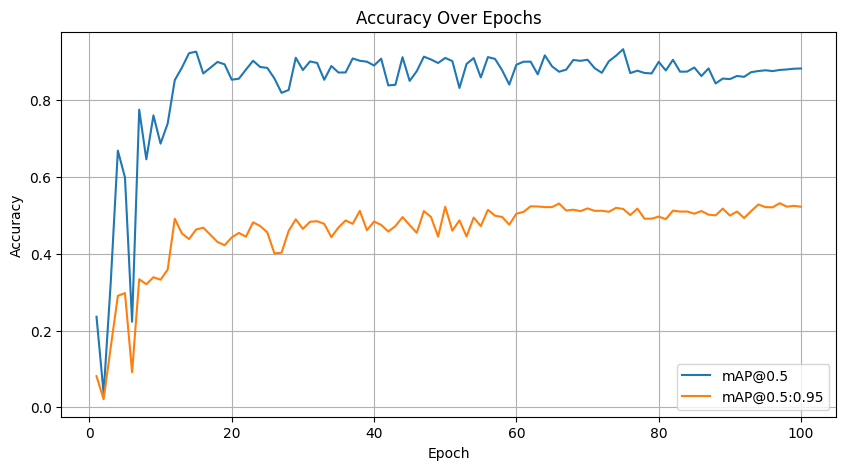

In [20]:
# Find the most recent training log directory
log_dir = max(glob('runs/detect/train*'), key = the_number_in_the_string)

# Load the training results from the CSV file
results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()  # Remove any leading/trailing whitespace from column names

# Extract epochs and accuracy metrics
epochs = results.index + 1  # Epochs are zero-indexed, so add 1
mAP_0_5 = results['metrics/mAP50(B)']  # Mean Average Precision at IoU=0.5
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']  # Mean Average Precision at IoU=0.5:0.95

# Plot the accuracy over epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Save the trained model
model.save('best_license_plate_model.pt')

In [22]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.

    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars425.png: 160x320 1 license_plate, 54.2ms
Speed: 0.9ms preprocess, 54.2ms inference, 9.1ms postprocess per image at shape (1, 3, 160, 320)


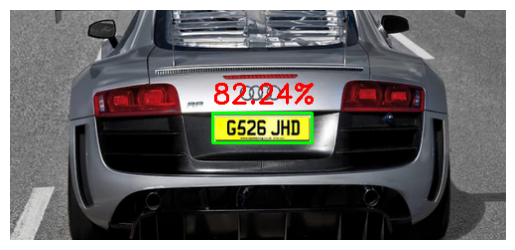

In [23]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars75.png: 224x320 2 license_plates, 41.8ms
Speed: 0.8ms preprocess, 41.8ms inference, 0.8ms postprocess per image at shape (1, 3, 224, 320)


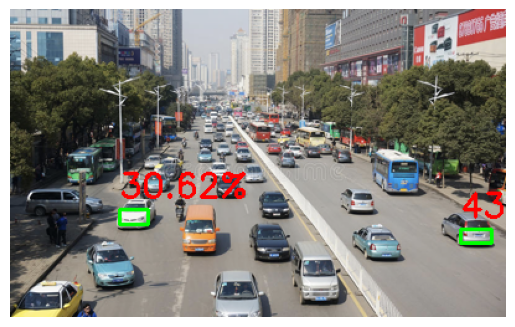

In [24]:
predict_and_plot(test.iloc[1].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 44.8ms
Speed: 0.8ms preprocess, 44.8ms inference, 0.7ms postprocess per image at shape (1, 3, 320, 192)


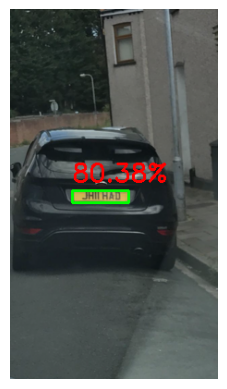

In [25]:
predict_and_plot(test.iloc[2].img_path)

In [26]:
%pip3 install pytesseract

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [27]:
import pytesseract
from pytesseract import Output

In [28]:
def predict_and_plot(path_test_car):
    """
    Predicts and plots the bounding boxes on the given test image using the trained YOLO model.
    Also performs OCR on the detected bounding boxes to extract text.
    
    Parameters:
    path_test_car (str): Path to the test image file.
    """
    # Perform prediction on the test image using the model
    results = model.predict(path_test_car, device='cpu')

    # Load the image using OpenCV
    image = cv2.imread(path_test_car)
    # Convert the image from BGR (OpenCV default) to RGB (matplotlib default)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract the bounding boxes and labels from the results
    for result in results:
        for box in result.boxes:
            # Get the coordinates of the bounding box
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            # Get the confidence score of the prediction
            confidence = box.conf[0]

            # Draw the bounding box on the image
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            # Draw the confidence score near the bounding box
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

            # Crop the bounding box from the image for OCR
            roi = image[y1:y2, x1:x2]

            # Perform OCR on the cropped image
            text = pytesseract.image_to_string(roi, config='--psm 6')
            print(f"Detected text: {text}")

    # Plot the image with bounding boxes
    plt.imshow(image)
    plt.axis('off')  # Hide the axis
    plt.show()  # Display the image


image 1/1 /kaggle/input/car-plate-detection/images/Cars152.png: 224x320 1 license_plate, 45.4ms
Speed: 2.3ms preprocess, 45.4ms inference, 1.0ms postprocess per image at shape (1, 3, 224, 320)
Detected text: = DL49 AK49.



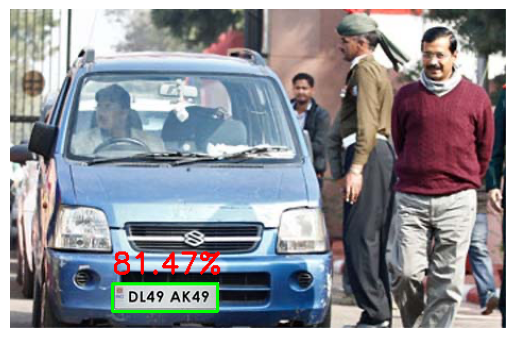

In [32]:
predict_and_plot(test.iloc[10].img_path)


image 1/1 /kaggle/input/car-plate-detection/images/Cars181.png: 320x192 1 license_plate, 32.7ms
Speed: 0.7ms preprocess, 32.7ms inference, 1.0ms postprocess per image at shape (1, 3, 320, 192)
Detected text: | JHU HAD |



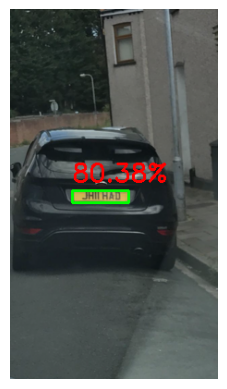

In [33]:
predict_and_plot(test.iloc[2].img_path)